In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [5]:
pwd()

'C:\\Users\\dell\\Downloads\\Py-DS-ML-Bootcamp-master'

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

train.head()

Train Shape:  (250, 302)
Test Shape:  (19750, 301)


,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


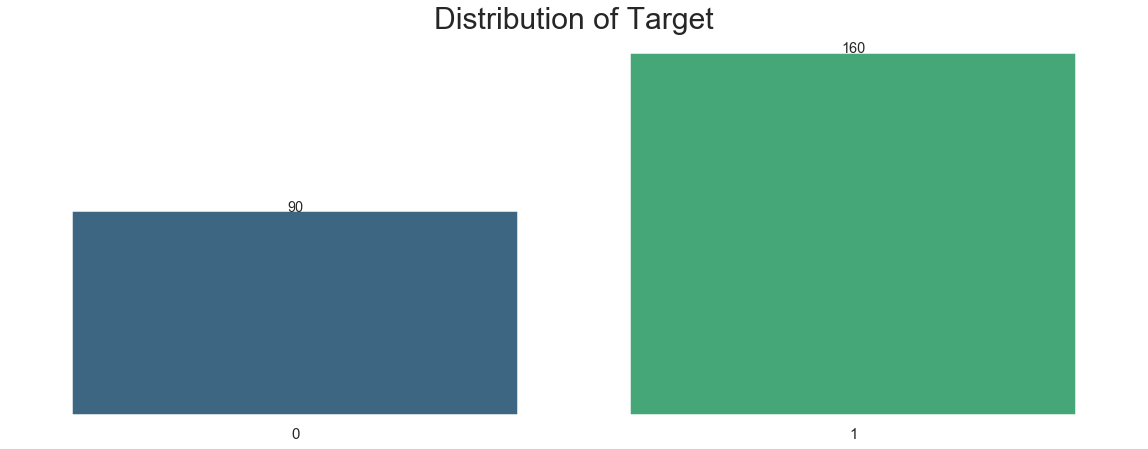

In [7]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(train.target, palette='viridis')
g.set_xticklabels(['0', '1'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Target', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [8]:
# prepare for modeling
X_train_df = train.drop(['id', 'target'], axis=1)
y_train = train['target']

X_test = test.drop(['id'], axis=1)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test)

In [9]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='roc_auc')
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.80729167 0.71875    0.734375   0.80034722 0.66319444]
RFC Scores:  [0.69010417 0.72569444 0.62847222 0.6796875  0.640625  ]


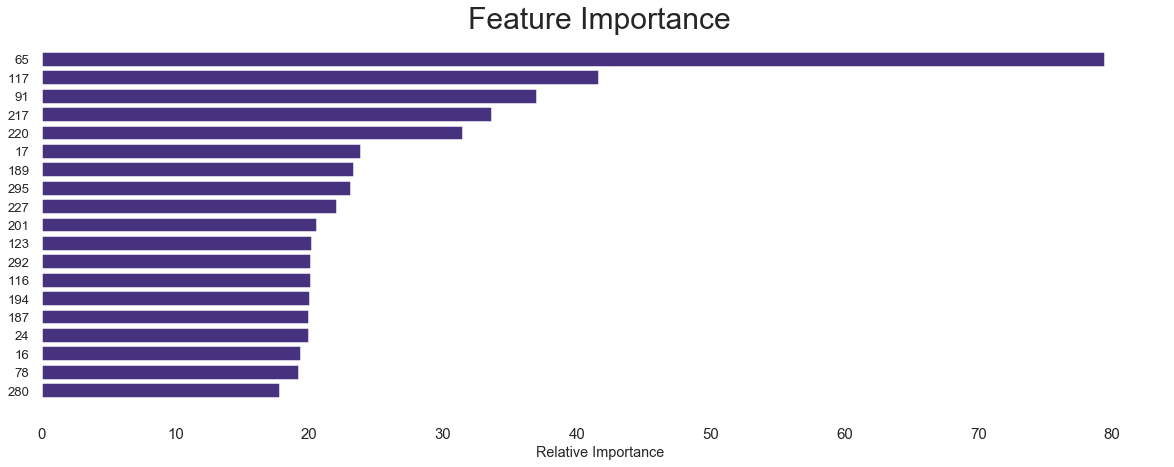

In [10]:
# checking which are the most important features
feature_importance = rfc.fit(X_train, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

In [11]:
# check missing values
train.isnull().any().any()

False

In [12]:
from sklearn import feature_selection

sel = feature_selection.VarianceThreshold()
train_variance = sel.fit_transform(train)
train_variance.shape

(250, 302)

In [13]:
# find correlations to target
corr_matrix = train.corr().abs()

print(corr_matrix['target'].sort_values(ascending=False).head(10))

target    1.000000
33        0.373608
65        0.293846
217       0.207215
117       0.197496
91        0.192536
24        0.173096
295       0.170501
73        0.167557
183       0.164146
Name: target, dtype: float64


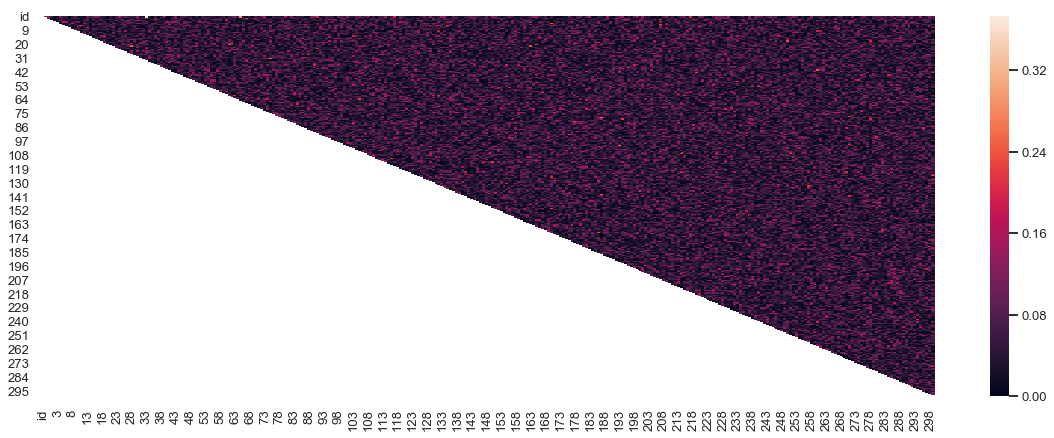

In [14]:
# Select upper triangle of correlation matrix
matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
sns.heatmap(matrix)
plt.show;


In [15]:
# Find index of feature columns with high correlation
to_drop = [column for column in matrix.columns if any(matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))

Columns to drop:  0


In [16]:
# feature extraction
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=100)
# fit on train set
fit = k_best.fit(X_train, y_train)
# transform train set
univariate_features = fit.transform(X_train)

In [17]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, univariate_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, univariate_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.89930556 0.93402778 0.89236111 0.96006944 0.94791667]
RFC Scores:  [0.77517361 0.82638889 0.80989583 0.875      0.79861111]


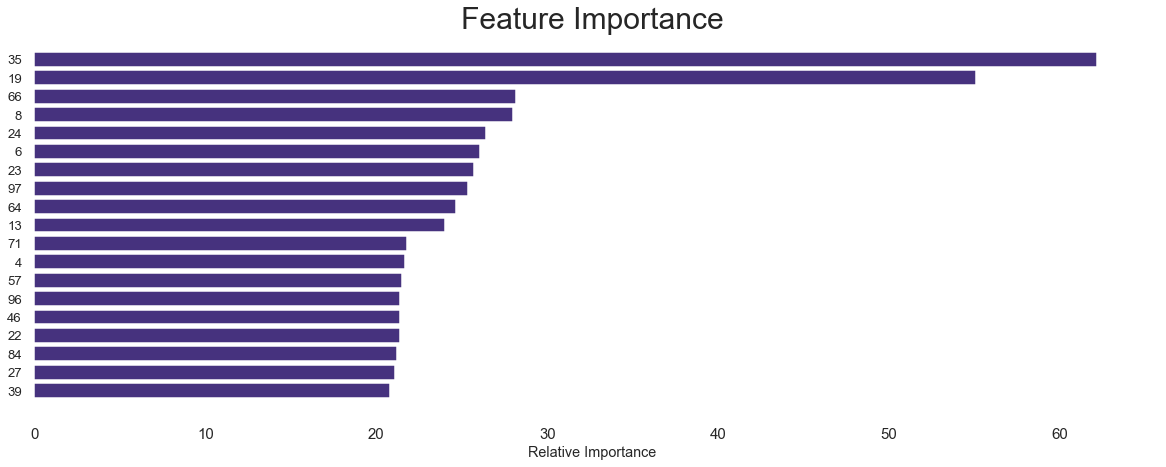

In [18]:
# checking which are the most important features
feature_importance = rfc.fit(univariate_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

In [19]:
# feature extraction
rfe = feature_selection.RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_features = fit.transform(X_train)

In [20]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=10)

lr_scores = cross_val_score(lr, recursive_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, recursive_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.99826389 0.99652778 0.984375   1.         0.99652778]
RFC Scores:  [0.67274306 0.80381944 0.54340278 0.71701389 0.67100694]


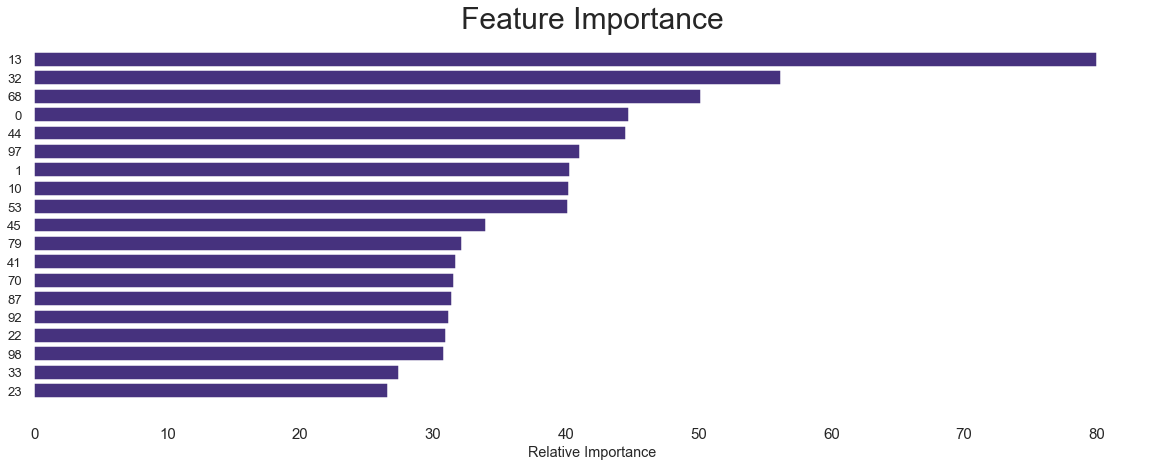

In [21]:
# checking which are the most important features
feature_importance = rfc.fit(recursive_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()


In [22]:
# feature extraction
select_model = feature_selection.SelectFromModel(lr)

# fit on train set
fit = select_model.fit(X_train, y_train)

# transform train set
model_features = fit.transform(X_train)

In [23]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, model_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, model_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.984375   0.99479167 0.97222222 0.99305556 0.99305556]
RFC Scores:  [0.71180556 0.8203125  0.73697917 0.84375    0.78732639]


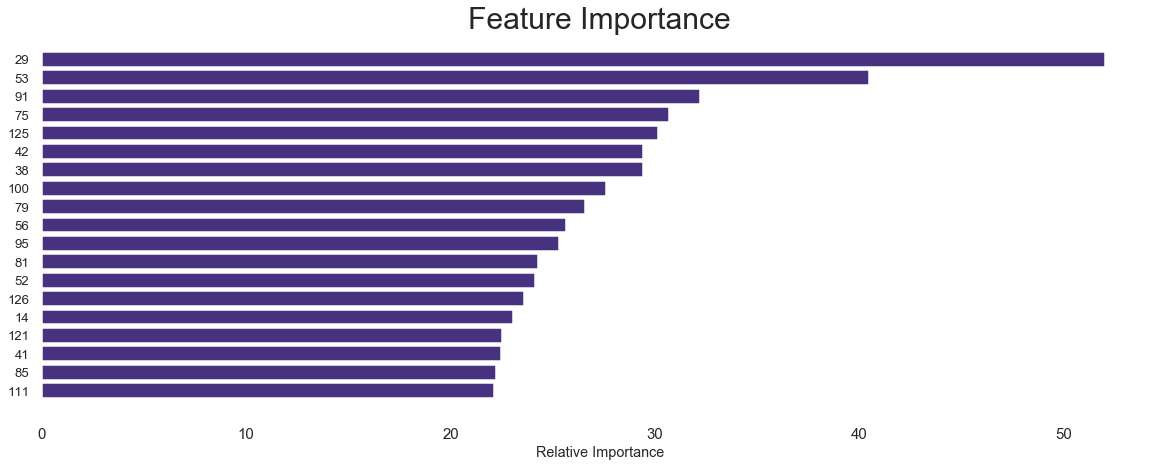

In [24]:
# checking which are the most important features
feature_importance = rfc.fit(model_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
##### Feature Extraction using PCA

In [25]:
from sklearn.decomposition import PCA
# pca - keep 90% of variance
pca = PCA(0.90)

principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(250, 139)

In [26]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.80902778 0.703125   0.734375   0.80555556 0.66145833]
RFC Scores:  [0.51822917 0.61371528 0.75954861 0.51996528 0.64670139]


In [27]:
# pca keep 75% of variance
pca = PCA(0.75)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(250, 93)

In [28]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.72048611 0.60069444 0.68402778 0.71006944 0.61284722]
RFC Scores:  [0.56423611 0.53645833 0.70833333 0.67361111 0.59461806]


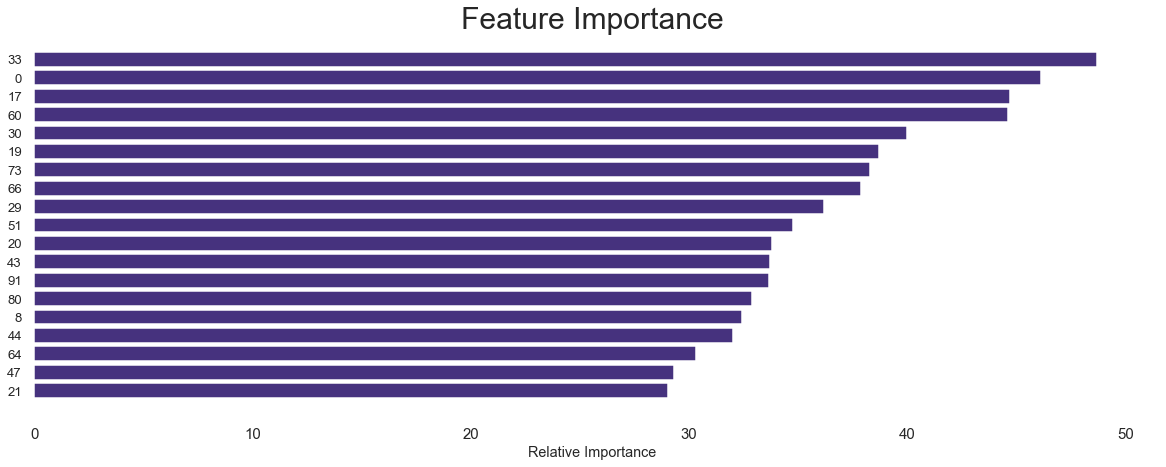

In [29]:
# checking which are the most important features
feature_importance = rfc.fit(principal_df, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

In [30]:
# feature extraction
rfe = feature_selection.RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_X_train = fit.transform(X_train)
recursive_X_test = fit.transform(X_test)

lr = LogisticRegression(C=1, class_weight={1:0.6, 0:0.4}, penalty='l1', solver='liblinear')
lr_scores = cross_val_score(lr, recursive_X_train, y_train, cv=5, scoring='roc_auc')
lr_scores.mean()

0.9059027777777778

In [31]:
predictions = lr.fit(recursive_X_train, y_train).predict_proba(recursive_X_test)


In [32]:
predictions

array([[0.27011411, 0.72988589],
       [0.40160759, 0.59839241],
       [0.14492675, 0.85507325],
       ...,
       [0.53712402, 0.46287598],
       [0.01298193, 0.98701807],
       [0.74789269, 0.25210731]])